## Setup

In [24]:
from functions import Model, get99, splitData, dropMissingValues, z_score, outliers_knn, outliers_dbscan, getNoise, getRelFeatures, drop_features, getCombinations, get_unique_list, bold, blue, red, green, getBestModel, np_to_df, df_to_np, drop99_all, z_score_individual, train_test_to_df, loadModel
import pandas as pd
from sklearn.linear_model import LinearRegression
import warnings
import json
import numpy as np
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from functions import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error

Json Hyper Parameters

In [25]:
# JSON file
f = open ('data/json/input.json', "r")
  # Reading from file
PARAMETERS_ALL = json.loads(f.read())
PARAMETERS = PARAMETERS_ALL["TESTING"]
SPLIT_SIZE = PARAMETERS["SPLIT_SIZE"]

OUTLIER99 = PARAMETERS["OUTLIER99"] 
OUTLIER_ZSCORE = {"STD" : PARAMETERS["OUTLIER_ZSCORE"]["STD"]}
OUTLIER_ZSCORE_IND = PARAMETERS["OUTLIER_ZSCORE_IND"]
OUTLIER_KNN = {"K": PARAMETERS["OUTLIER_KNN"]["K"], "X": PARAMETERS["OUTLIER_KNN"]["X"]}
OUTLIER_DBSCAN = {"K": PARAMETERS["OUTLIER_DBSCAN"]["K"], "X": PARAMETERS["OUTLIER_DBSCAN"]["X"], "EPS": PARAMETERS["OUTLIER_DBSCAN"]["EPS"], "MIN_SAMPLES":  PARAMETERS["OUTLIER_DBSCAN"]["MIN_SAMPLES"]}
OUTLIER_NOISE = {"CV": PARAMETERS["OUTLIER_NOISE"]["CV"], "DEPTH": PARAMETERS["OUTLIER_NOISE"]["DEPTH"], "MULTI": PARAMETERS["OUTLIER_NOISE"]["MULTI"] }

FEATURE_SEL_CORR = {"THRESHOLD_CORR": PARAMETERS["FEATURE_SEL_CORR"]["THRESHOLD"]}

f.close()

Get Data from CSV

In [26]:
#Get test Data
NAME_TEST_FILE = "house_data_testing"
df_test_data = pd.read_csv("data/csv/"+NAME_TEST_FILE+".csv", sep=';') 
# remove unnamed column
df_test_data = df_test_data.iloc[:, 1:]
#Transform string to datetime
df_test_data["date"] = pd.to_datetime(df_test_data["date"])

Missing Values

In [27]:
df_test_data = dropMissingValues(df_test_data) 
print("outlier_99")
outlier_list_99 = get99(df_test_data) #TODO Mean for price for trainingsdata
df_test_data = drop99_all(df_test_data, outlier_list_99)
print(green('done'), "\n")

outlier_99
done 



In [28]:
df_test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 597 entries, 0 to 613
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             597 non-null    int64         
 1   date           597 non-null    datetime64[ns]
 2   price          597 non-null    float64       
 3   bedrooms       597 non-null    int64         
 4   bathrooms      597 non-null    float64       
 5   sqft_living    597 non-null    int64         
 6   sqft_lot       597 non-null    int64         
 7   floors         597 non-null    float64       
 8   waterfront     597 non-null    float64       
 9   dis_super      597 non-null    float64       
 10  view           597 non-null    float64       
 11  condition      597 non-null    float64       
 12  grade          597 non-null    float64       
 13  sqft_above     597 non-null    float64       
 14  sqft_basement  597 non-null    float64       
 15  yr_built       597 non-

##

## Testdata

In [29]:
model_obj = loadModel()


Model: Lasso(alpha=5) Combination: ('db_scan_4_500_0.4_8', 'noise_5_5_10') Features: 22


In [30]:
#set new test Data
X_train, X_test, y_train, y_test = model_obj.get_data()
#print(type(X_test), type(y_test))
X_test, y_test = df_test_data.drop(columns=["price", "date", "id"]), df_test_data["price"]
scaler = StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)
model_obj.set_data(X_train, X_test, y_train, y_test)
#Train Model
model_obj.train()
mae, score = model_obj.summary()
predictions = model_obj.pred()
print("MAE: ", mae)

df_test_data["price_pred"]  = predictions
df_test_data["diff"] = df_test_data["price"]  - df_test_data["price_pred"]  
df_test_data.loc[:, ["price", "price_pred", "diff"]]


MAE:  113526.86


,price,price_pred,diff
0,336000.0,3.356885e+05,311.531319
1,1600000.0,1.208762e+06,391238.307849
2,460000.0,5.365661e+05,-76566.129095
3,998500.0,6.856089e+05,312891.058438
4,745000.0,6.783095e+05,66690.513131
...,...,...,...
609,739000.0,5.860320e+05,152967.953563
610,710000.0,6.399731e+05,70026.904131
611,475000.0,5.803292e+05,-105329.224406
612,340000.0,4.510543e+05,-111054.337692


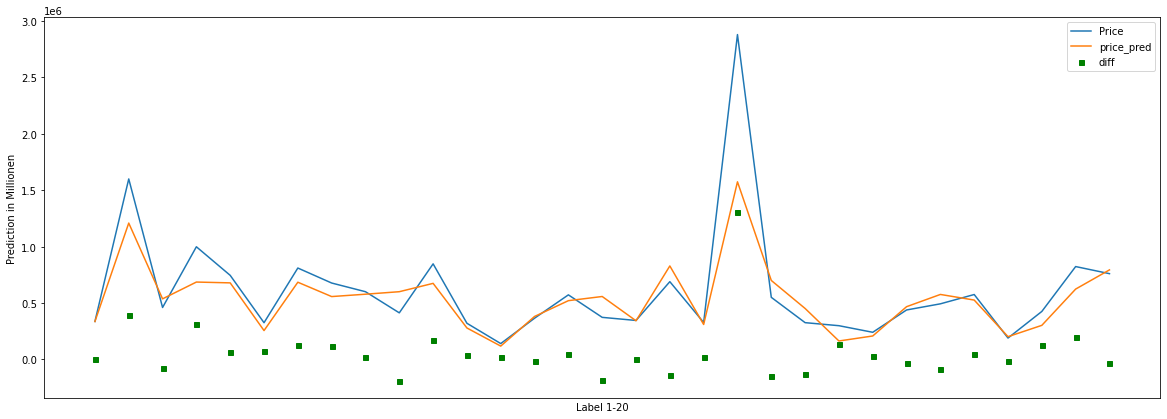

In [31]:
plt.figure(figsize=(20,7))
#Prediction der Modelle für die ersten 20 Zeilen
x = 30
real = df_test_data.loc[:x, "price"]
pred = df_test_data.loc[:x,"price_pred"]
diff = df_test_data.loc[:x,"diff"]

plt.plot(real, label="Price")
plt.plot(pred, label="price_pred")
plt.plot(diff, "gs", ms=5, label="diff")

plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("Prediction in Millionen")
plt.xlabel("Label 1-20")
plt.legend(loc="best")

plt.show()

In [32]:
#df_test_data[["price", "price_pred"]].describe()
df_test_data.loc[:, ["price", "price_pred", "diff"]].describe()

,price,price_pred,diff
count,5.970000e+02,5.970000e+02,5.970000e+02
mean,5.243022e+05,4.772168e+05,4.708543e+04
std,3.200201e+05,2.352965e+05,1.891784e+05
min,1.750000e+04,-1.729554e+05,-6.424465e+05
25%,3.321000e+05,3.216835e+05,-3.834535e+04
50%,4.654250e+05,4.577674e+05,3.568447e+04
75%,6.250000e+05,6.016043e+05,1.090832e+05
max,2.950000e+06,1.574659e+06,1.874003e+06


In [33]:
#TODO sqft_living wenn price auffällig niedrig obwohl m² hoch clsuter
#TODO PCA macht warscheinlich wenig sinn